In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import sys
import os

# A. Dataset Introduction


Dataset yang akan digunakan didapatkan dari website kaggle (https://www.kaggle.com/datasets/knightbearr/sales-product-data?datasetId=1695352&sortBy=voteCount).

## **Context**

Sales analytics is the practice of generating insights from sales data, trends, and metrics to set targets and forecast future sales performance. Sales analysis is mining your data to evaluate the performance of your sales team against its goals. It provides insights about the top performing and underperforming products/services, the problems in selling and market opportunities, sales forecasting, and sales activities that generate revenue.

## **Content**

- **Order ID** - An Order ID is the number system that Amazon uses exclusively to keep track of orders. Each order receives its own Order ID that will not be duplicated. This number can be useful to the seller when attempting to find out certain details about an order such as shipment date or status.

- **Product** - The product that have been sold.

- **Quantity Ordered** - Ordered Quantity is the total item quantity ordered in the initial order (without any changes).

- **Price Each** - The price of each products.

- **Order Date** - This is the date the customer is requesting the order be shipped.

- **Purchase Address** - The purchase order is prepared by the buyer, often through a purchasing department. The purchase order, or PO, usually includes a PO number, which is useful in matching shipments with purchases; a shipping date; billing address; shipping address; and the request items, quantities and price.

## **Target**

A target market analysis is an assessment of how your product or service fits into a specific market and where it will gain the most.

## **Task**

1. What was the best month for sales? How much was earned that month?

2. What City had the highest number of sales?

3. What time should we display adverstisement to maximize likelihood of customer's buying product?

4. What products are most often sold together?

5. What product sold the most? Why do you think it sold the most?


## **Probability**

1. How much probability for next people will ordered USB-C Charging Cable?

2. How much probability for next people will ordered iPhone?

3. How much probability for next people will ordered Google Phone?

4. How much probability other peoples will ordered Wired Headphones?

# B. Dataset Understanding

## **Import and Read Data**

In [ ]:
files = [j for j in os.listdir('/content/drive/MyDrive/Apa aja yang gajelas/Sales Product Data/Data')]

# let's make a pandas DataFrame
data_raw = pd.DataFrame()

# makes a loop for concat the data
for file in files:
    data = pd.read_csv('/content/drive/MyDrive/Apa aja yang gajelas/Sales Product Data/Data/' + file)
    data_raw  = pd.concat([data_raw , data])

In [ ]:
data_raw.sample(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
13181,189123,27in 4K Gaming Monitor,1,389.99,04/17/19 00:58,"184 Highland St, San Francisco, CA 94016"
54,194148,27in 4K Gaming Monitor,1,389.99,05/21/19 07:37,"312 Church St, San Francisco, CA 94016"
1752,178222,20in Monitor,1,109.99,04/14/19 12:04,"453 Park St, New York City, NY 10001"
16301,311247,27in 4K Gaming Monitor,1,389.99,12/22/19 19:12,"18 5th St, New York City, NY 10001"
11332,247510,USB-C Charging Cable,1,11.95,08/26/19 16:41,"44 Cedar St, Los Angeles, CA 90001"
5986,199777,Lightning Charging Cable,1,14.95,05/31/19 00:34,"317 11th St, New York City, NY 10001"
8706,303967,Apple Airpods Headphones,1,150,12/19/19 10:37,"146 Hill St, Atlanta, GA 30301"
1177,163127,Wired Headphones,1,11.99,03/08/19 21:44,"415 Hill St, Boston, MA 02215"
7297,201025,Bose SoundSport Headphones,1,99.99,05/04/19 19:51,"44 West St, Dallas, TX 75001"
1605,224458,Lightning Charging Cable,1,14.95,07/04/19 13:37,"690 Jefferson St, San Francisco, CA 94016"


## **Check Data Type**

In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186850 entries, 0 to 16634
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 10.0+ MB


## **Check Missing Value**

In [ ]:
data_null = data_raw.isnull().sum().reset_index()
data_null.columns = ['feature','missing_value']
data_null['percentage'] = round((data_null['missing_value']/len(data_raw))*100,2)
data_null = data_null.sort_values('percentage', ascending=False).reset_index(drop=True)
data_null = data_null[data_null['percentage']>0]
data_null

,feature,missing_value,percentage
0,Order ID,545,0.29
1,Product,545,0.29
2,Quantity Ordered,545,0.29
3,Price Each,545,0.29
4,Order Date,545,0.29
5,Purchase Address,545,0.29


## **Check Duplicated Value** 

In [ ]:
print('Total of data duplicated :', data_raw.duplicated().sum(), '\n')
data_raw[data_raw.duplicated()]

Total of data duplicated : 1162 



,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
678,NaN,NaN,NaN,NaN,NaN,NaN
797,NaN,NaN,NaN,NaN,NaN,NaN
875,142071,AA Batteries (4-pack),1,3.84,01/17/19 23:02,"131 2nd St, Boston, MA 02215"
876,NaN,NaN,NaN,NaN,NaN,NaN
1102,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
...,...,...,...,...,...,...
16191,NaN,NaN,NaN,NaN,NaN,NaN
16234,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
16379,NaN,NaN,NaN,NaN,NaN,NaN
16505,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


## **Observation**

From Dataset, we know that:

1. Several columns, such as `Quantity Ordered` , `Price Each` , and `Order Date` has an **incorrect data type**.

2. There are **missing values**, about **0.29%** of total data.

3. There are **duplicate values**, about 1162 rows of total data.

What to do next:

1. Delete rows that contain missing values.

2. Remove duplicate data.

3. Change the data type that does not match.

4. Extract year, quarter, month, and time data from columns `Order Date`.

5. Extract city data from column `Purchase Address`.

6. Extract total sales from columns `Quantity Ordered` and `Price Each`.

# C. Pre-Processing

In [ ]:
data = data_raw.copy()

## **Handling Missing Value**

Deleted data rows that have missing values, because the amount of missing data is very small, which is 0.29% of the total data.

In [ ]:
data = data.dropna()
data.isna().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

## **Handling Duplicated Value**

Duplicate data is deleted, so there is no double stored.


In [ ]:
data = data.drop_duplicates()
print('Total of data duplicated after Handled :', data.duplicated().sum(), '\n')

Total of data duplicated after Handled : 0 



## Change the data type

In [ ]:
data = data[data['Order Date'].str[0:2] != 'Or']

data['Order ID'] = data['Order ID'].astype(int)
data['Quantity Ordered'] = data['Quantity Ordered'].astype(int)
data['Price Each'] = data['Price Each'].astype(float)
data['Order Date'] = pd.to_datetime(data['Order Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185686 entries, 0 to 16634
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185686 non-null  int64         
 1   Product           185686 non-null  object        
 2   Quantity Ordered  185686 non-null  int64         
 3   Price Each        185686 non-null  float64       
 4   Order Date        185686 non-null  datetime64[ns]
 5   Purchase Address  185686 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.9+ MB


In [ ]:
data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301"


## **Extract Data**

In [ ]:
def extract_data(DataFrame):

  DataFrame['Year'] = pd.DatetimeIndex(DataFrame['Order Date']).year

  DataFrame['Month'] = pd.DatetimeIndex(DataFrame['Order Date']).month

  DataFrame['Hour'] = pd.DatetimeIndex(DataFrame['Order Date']).hour

  def city(address):
    return address.split(',')[1]

  DataFrame['City'] = DataFrame['Purchase Address'].apply(lambda x: f"{city(x)}")

  DataFrame['Total Sales'] = DataFrame['Quantity Ordered'] * DataFrame['Price Each']

  return DataFrame

In [ ]:
data = extract_data(data)
data['Quarter'] = np.where(data['Month'] <= 3, 1,
                           np.where(data['Month'] >= 10, 4,
                                    np.where((data['Month'] > 3) & (data['Month'] <= 6), 2, 3
                                             )))

In [ ]:
data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Year,Month,Hour,City,Total Sales,Quarter
0,141234,iPhone,1,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",2019,1,21,Boston,700.00,1
1,141235,Lightning Charging Cable,1,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035",2019,1,14,Portland,14.95,1
2,141236,Wired Headphones,2,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",2019,1,13,San Francisco,23.98,1
3,141237,27in FHD Monitor,1,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001",2019,1,20,Los Angeles,149.99,1
4,141238,Wired Headphones,1,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",2019,1,11,Austin,11.99,1


# D. Exploratory Data Analysis

In [ ]:
df = data.copy()

data[data['Year']!=2019]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Year,Month,Hour,City,Total Sales,Quarter
1563,297150,Lightning Charging Cable,1,14.95,2020-01-01 00:38:00,"427 Wilson St, Dallas, TX 75001",2020,1,0,Dallas,14.95,1
2265,297817,iPhone,1,700.00,2020-01-01 00:22:00,"519 13th St, New York City, NY 10001",2020,1,0,New York City,700.00,1
2266,297817,Lightning Charging Cable,2,14.95,2020-01-01 00:22:00,"519 13th St, New York City, NY 10001",2020,1,0,New York City,29.90,1
2425,297969,Google Phone,1,600.00,2020-01-01 00:54:00,"542 2nd St, San Francisco, CA 94016",2020,1,0,San Francisco,600.00,1
2806,298344,Wired Headphones,4,11.99,2020-01-01 03:34:00,"731 7th St, New York City, NY 10001",2020,1,3,New York City,47.96,1
3553,299049,Apple Airpods Headphones,1,150.00,2020-01-01 01:17:00,"762 Johnson St, San Francisco, CA 94016",2020,1,1,San Francisco,150.00,1
3633,299125,USB-C Charging Cable,1,11.95,2020-01-01 04:21:00,"754 Hickory St, New York City, NY 10001",2020,1,4,New York City,11.95,1
4941,300362,USB-C Charging Cable,1,11.95,2020-01-01 00:59:00,"581 River St, San Francisco, CA 94016",2020,1,0,San Francisco,11.95,1
5103,300519,Bose SoundSport Headphones,1,99.99,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001",2020,1,5,New York City,99.99,1
5104,300519,Lightning Charging Cable,1,14.95,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001",2020,1,5,New York City,14.95,1


In [ ]:
print('\n Total order not in 2019 :', len(data[data['Year']!=2019]))


 Total order not in 2019 : 34


**Notes**:

There are 34 data orders made in 2020. It can be seen that orders in 2020 were only recorded in January (1). Therefore, this analysis will focus on 2019.

## **Task**

### **1. What was the best quarter for sales? How much was earned that quarter?**

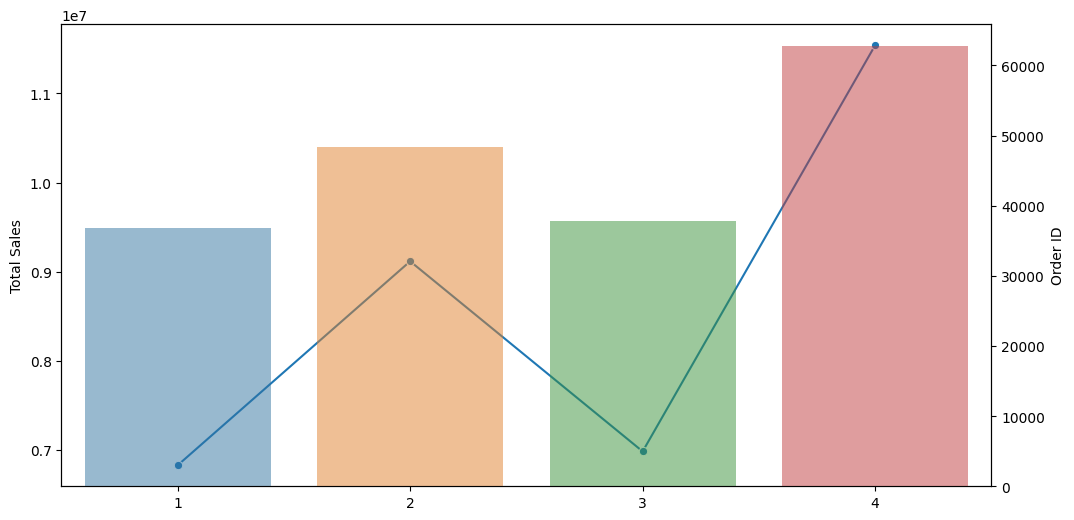

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

order_per_quarter = df.groupby('Quarter')[['Order ID']].count().sort_values('Quarter').reset_index()
sales_per_quarter = df.groupby('Quarter')[['Total Sales']].sum().sort_values('Quarter').reset_index()

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = sales_per_quarter['Total Sales'], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot(data = order_per_quarter, x='Quarter', y='Order ID', alpha=0.5, ax=ax2)

### **2. What was the best month for sales? How much was earned that month?**

### **3. What City had the highest number of sales?**

### **4. What time should we display adverstisement to maximize likelihood of customer's buying product?**

### **5. What products are most often sold together?**

### **6. What product sold the most? Why do you think it sold the most?**

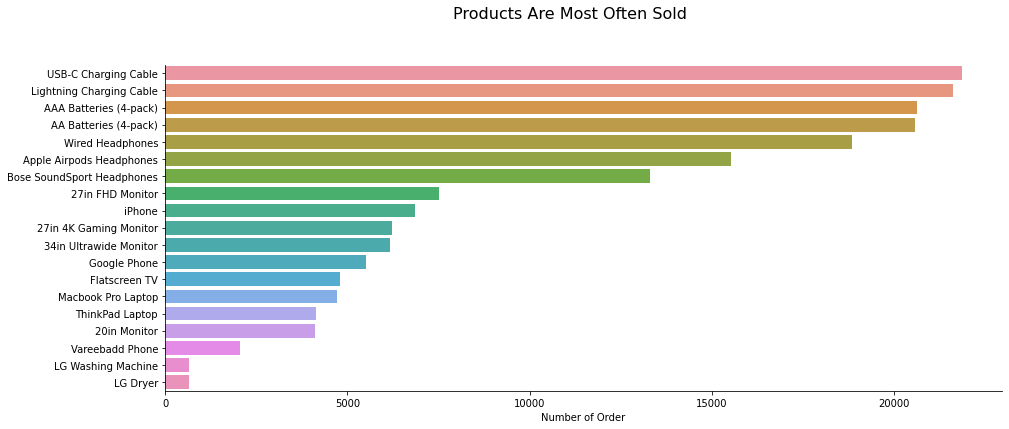

In [ ]:
product = df.groupby('Product')[['Order ID']].count().sort_values('Order ID', ascending=False).reset_index()

fig, ax = plt.subplots(1, 1,figsize=(15,6))
fig.suptitle("Products Are Most Often Sold", fontsize=16, verticalalignment="bottom")

sns.barplot(x='Order ID', y='Product', data=product)
ax.set_ylabel('')    
ax.set_xlabel('Number of Order')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

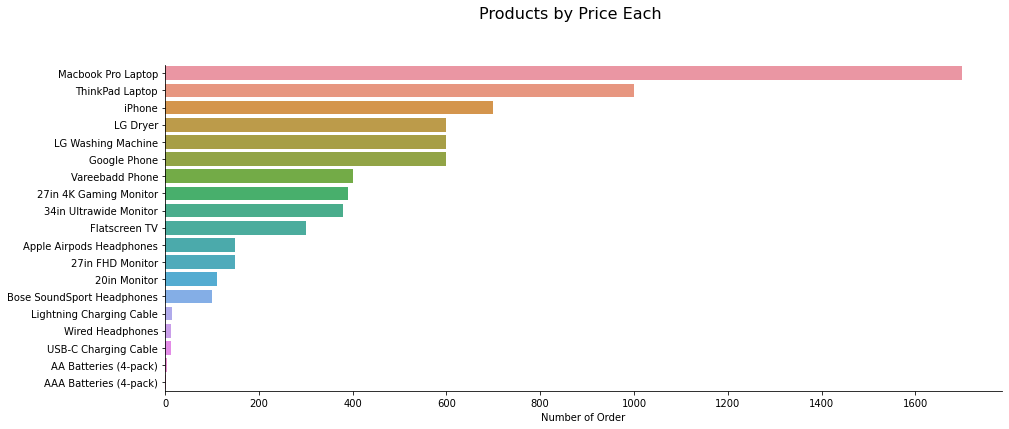

In [ ]:
product = df.groupby('Product')[['Price Each']].mean().sort_values('Price Each', ascending=False).reset_index()

fig, ax = plt.subplots(1, 1,figsize=(15,6))
fig.suptitle("Products by Price Each", fontsize=16, verticalalignment="bottom")

sns.barplot(x='Price Each', y='Product', data=product)
ax.set_ylabel('')    
ax.set_xlabel('Number of Order')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)